In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from src.simulation_options import simulateSinglePorosity

In [2]:
df = pd.read_csv("../lhs_results/SinglePorosityTwoFractureSimulationRuns.csv")
df = df.sort_values('MSE').reset_index(drop=True)
df.head(8)


,iteration,mean_residence_time_1,peclet_number_1,mean_residence_time_2,peclet_number_2,fractional_recovery,MSE,R2
0,7030,37.475580,1.885552,14.553631,12.690903,0.731288,0.000939,0.926946
1,6235,13.674116,25.118189,35.542481,1.554751,0.080959,0.001174,0.908691
2,8109,10.389143,49.651821,27.783494,2.633935,0.091410,0.001242,0.903417
3,6242,9.176907,95.134912,27.475221,3.377050,0.052906,0.001281,0.900407
4,6265,47.993414,1.203884,12.920855,17.093455,0.959871,0.001296,0.899194
5,2443,12.798248,7.212351,33.931319,3.273512,0.369307,0.001374,0.893181
6,5096,26.805205,2.924895,48.199927,44.478610,0.920523,0.001409,0.890439
7,2955,27.042283,2.917003,41.706166,98.070957,0.938905,0.001511,0.882465


In [3]:
# --- Pull params for this index (unchanged) ---
idx = 5
mrt_1 = df.loc[idx, 'mean_residence_time_1']
pec_1 = df.loc[idx, 'peclet_number_1']

mrt_2 = df.loc[idx, 'mean_residence_time_2']
pec_2 = df.loc[idx, 'peclet_number_2']

fr  = df.loc[idx, 'fractional_recovery']

# --- Time and constants ---
time_points   = np.linspace(0.00001, 130, 500)
bckgrnd_conc  = 11.0
base_inj_concs = np.array([0.01, bckgrnd_conc], dtype=float)
t_values = [1.0, 3.0, 5.0, 7.5]


# --- Frac-retard cases to compare ---
frac_retard_cases = [1.5, 3.5]

# --- Storage: dict[frac_retard] -> 2D array (len(t_values) x len(time_points)) ---
combined_results_by_frr = {}

for frr in frac_retard_cases:
    combined_results = np.zeros((len(t_values), len(time_points)))
    for k, t in enumerate(t_values):
        inj_durs = np.cumsum(np.array([t], dtype=float))

        first_component = simulateSinglePorosity(
            mrt_1, pec_1, frr, time_points, bckgrnd_conc, base_inj_concs, inj_durs
        )

        second_component = simulateSinglePorosity(
            mrt_2, pec_2, frr, time_points, bckgrnd_conc, base_inj_concs, inj_durs
        )

        first_component  = (first_component  - bckgrnd_conc) * fr       + bckgrnd_conc
        second_component = (second_component - bckgrnd_conc) * (1 - fr) + bckgrnd_conc
        combined = first_component + second_component - bckgrnd_conc

        combined_results[k, :] = combined

    combined_results_by_frr[frr] = combined_results




In [4]:
import numpy as np
import pandas as pd

# Build a single sheet: time + one column per (R, t) combination
out_cols = {"time_hr": np.asarray(time_points, dtype=float)}

for frr in frac_retard_cases:                         # preserve your chosen order
    arr = combined_results_by_frr[frr]               # shape: (len(t_values), len(time_points))
    for k, t in enumerate(t_values):
        col_name = f"R={frr:g}__t={t:g}hr"
        out_cols[col_name] = np.asarray(arr[k, :], dtype=float)

df_out = pd.DataFrame(out_cols)

# Save to CSV (single sheet)
path = "../outputs/Figure_8_a_b.csv"
df_out.to_csv(path, index=False)
print(f"Saved: {path}")


Saved: ../outputs/Figure_8_a_b.csv


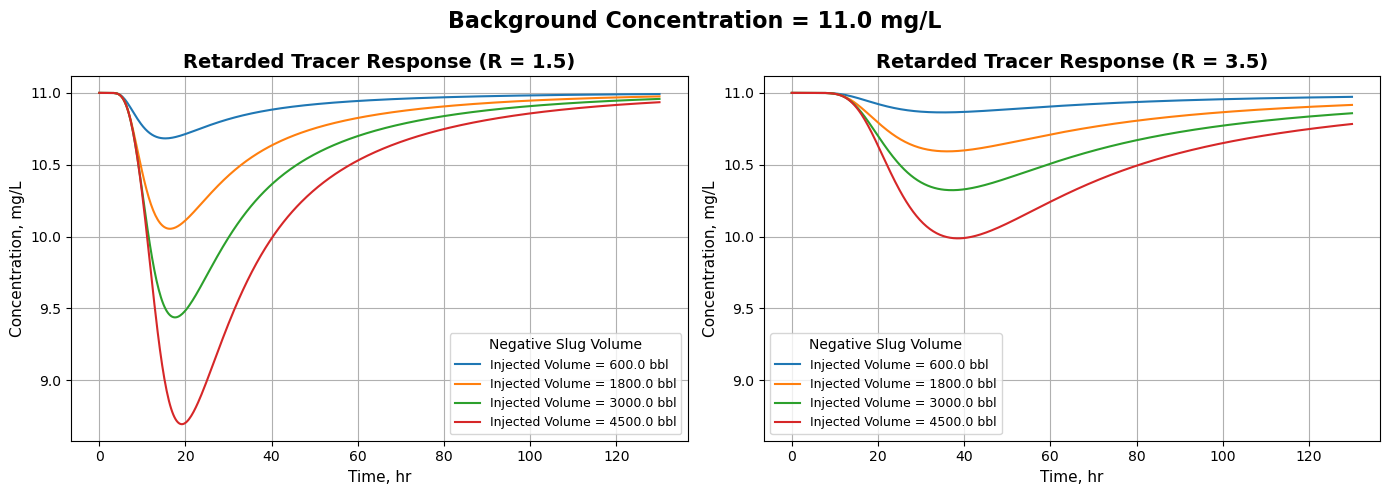

In [ ]:
# --- Plot: two subplots (1 row) for frr = 1.5 and 3.5 ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axes = axes.flatten()

for ax, frr in zip(axes, frac_retard_cases):
    curves = combined_results_by_frr[frr]
    for k, t in enumerate(t_values):
        ax.plot(time_points, curves[k, :], label=f"Injected Volume = {t * 60 * 10} bbl")
    ax.set_title(f"Retarded Tracer Response (R = {frr})", fontsize=14, fontweight="bold")
    ax.set_xlabel("Time, hr", fontsize=11)
    ax.grid(True)
    ax.legend(title="Negative Slug Volume", fontsize=9, title_fontsize=10)

# Left subplot: standard left-side y label/ticks
axes[0].set_ylabel("Concentration, mg/L", fontsize=11)
axes[0].yaxis.set_ticks_position('left')
axes[0].tick_params(labelleft=True, left=True)

# Right subplot: also force left-side y label/ticks (no right-side)
axes[1].yaxis.set_ticks_position('left')          # ticks only on the left
axes[1].tick_params(labelleft=True, left=True,    # show left tick labels
                    labelright=False, right=False)
axes[1].yaxis.set_label_position("left")          # label on the left
axes[1].set_ylabel("Concentration, mg/L", fontsize=11)

fig.suptitle(f"Background Concentration = {bckgrnd_conc} mg/L", fontsize=16, fontweight="bold")



# axes[0].set_ylim([9.3, 11.1])
# axes[1].set_ylim([9.3, 11.1])

fig.tight_layout()

# os.makedirs('Figures', exist_ok=True)
# plt.savefig('Figures/Figure_8_a_b.jpg', dpi=300)


plt.show()



In [6]:
# --- Pull params for this index (unchanged) ---
idx = 5
mrt_1 = df.loc[idx, 'mean_residence_time_1']
pec_1 = df.loc[idx, 'peclet_number_1']

mrt_2 = df.loc[idx, 'mean_residence_time_2']
pec_2 = df.loc[idx, 'peclet_number_2']

fr  = df.loc[idx, 'fractional_recovery']

# --- Time and constants ---
time_points   = np.linspace(0.00001, 130, 500)
bckgrnd_conc  = 18.0
base_inj_concs = np.array([0.01, bckgrnd_conc], dtype=float)
t_values = [1.0, 3.0, 5.0, 7.5]


# --- Frac-retard cases to compare ---
frac_retard_cases = [1.5, 3.5]

# --- Storage: dict[frac_retard] -> 2D array (len(t_values) x len(time_points)) ---
combined_results_by_frr = {}

for frr in frac_retard_cases:
    combined_results = np.zeros((len(t_values), len(time_points)))
    for k, t in enumerate(t_values):
        inj_durs = np.cumsum(np.array([t], dtype=float))

        first_component = simulateSinglePorosity(
            mrt_1, pec_1, frr, time_points, bckgrnd_conc, base_inj_concs, inj_durs
        )

        second_component = simulateSinglePorosity(
            mrt_2, pec_2, frr, time_points, bckgrnd_conc, base_inj_concs, inj_durs
        )

        first_component  = (first_component  - bckgrnd_conc) * fr       + bckgrnd_conc
        second_component = (second_component - bckgrnd_conc) * (1 - fr) + bckgrnd_conc
        combined = first_component + second_component - bckgrnd_conc

        combined_results[k, :] = combined

    combined_results_by_frr[frr] = combined_results




In [7]:
import numpy as np
import pandas as pd

# Build a single sheet: time + one column per (R, t) combination
out_cols = {"time_hr": np.asarray(time_points, dtype=float)}

for frr in frac_retard_cases:                         # preserve your chosen order
    arr = combined_results_by_frr[frr]               # shape: (len(t_values), len(time_points))
    for k, t in enumerate(t_values):
        col_name = f"R={frr:g}__t={t:g}hr"
        out_cols[col_name] = np.asarray(arr[k, :], dtype=float)

df_out = pd.DataFrame(out_cols)

# Save to CSV (single sheet)
path = "../outputs/Figure_8_c_d.csv"
df_out.to_csv(path, index=False)
print(f"Saved: {path}")


Saved: ../outputs/Figure_8_c_d.csv


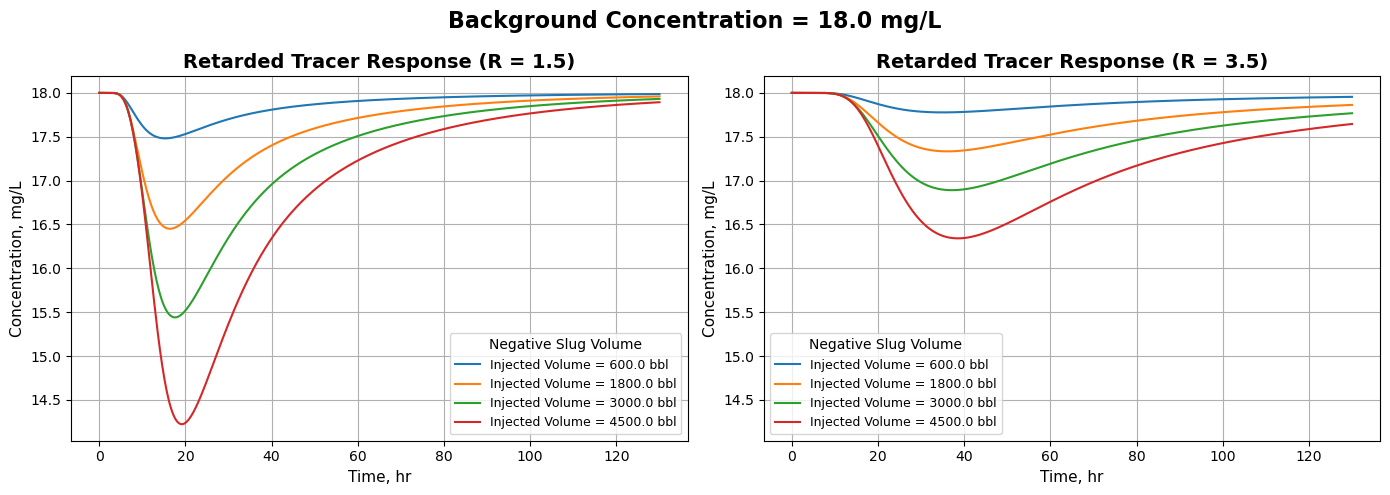

In [8]:
# --- Plot: two subplots (1 row) for frr = 1.5 and 3.5 ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axes = axes.flatten()

for ax, frr in zip(axes, frac_retard_cases):
    curves = combined_results_by_frr[frr]
    for k, t in enumerate(t_values):
        ax.plot(time_points, curves[k, :], label=f"Injected Volume = {t * 60 * 10} bbl")
    ax.set_title(f"Retarded Tracer Response (R = {frr})", fontsize=14, fontweight="bold")
    ax.set_xlabel("Time, hr", fontsize=11)
    ax.grid(True)
    ax.legend(title="Negative Slug Volume", fontsize=9, title_fontsize=10)

# Left subplot: standard left-side y label/ticks
axes[0].set_ylabel("Concentration, mg/L", fontsize=11)
axes[0].yaxis.set_ticks_position('left')
axes[0].tick_params(labelleft=True, left=True)

# Right subplot: also force left-side y label/ticks (no right-side)
axes[1].yaxis.set_ticks_position('left')          # ticks only on the left
axes[1].tick_params(labelleft=True, left=True,    # show left tick labels
                    labelright=False, right=False)
axes[1].yaxis.set_label_position("left")          # label on the left
axes[1].set_ylabel("Concentration, mg/L", fontsize=11)

fig.suptitle(f"Background Concentration = {bckgrnd_conc} mg/L", fontsize=16, fontweight="bold")



# axes[0].set_ylim([9.3, 11.1])
# axes[1].set_ylim([9.3, 11.1])

fig.tight_layout()

# os.makedirs('Figures', exist_ok=True)
# plt.savefig('Figures/Figure_8_c_d.jpg', dpi=300)


plt.show()

